In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas
import numpy

In [17]:
def vocabulary_size(data, column="Cognate_Set"):
    """Count different words in vocabulary."""
    return len(set(data[column]))

In [18]:
def semantic_width(data, column="Cognate_Set"):
    """Calculate average synonym count.

    Calculate the average weighted semantic width in the language
    represented by data.

    """
    width = 0
    m = 0
    for form, meanings in data.groupby(column):
        width += meanings["Weight"].sum()**2/(meanings["Weight"]**2).sum()
        m += 1
    return width/m

In [19]:
def synonymity(data):
    """Calculate average synonym count.

    Calculate the average weighted synonym count in the language
    represented by data.

    """
    return semantic_width(data, column="Feature_ID")

In [20]:
try:
    clics_words = pandas.read_csv("words.csv")
except FileNotFoundError:
    import urllib.request
    data = urllib.request.urlopen(
        "https://github.com/clics/clics-data/blob/master/data/words.csv?raw=true")
    clics_words = pandas.read_csv(data)

clics_words["Weight"] = 1

clics_vocabulary = []
clics_semantic_width = []
clics_synonymity = []
for language, words in clics_words.groupby("LanguageId"):
    clics_vocabulary.append(vocabulary_size(words, "ClicsValue"))
    clics_semantic_width.append(semantic_width(words, "ClicsValue"))
    clics_synonymity.append(semantic_width(words, "ConcepticonGloss"))

In [21]:
path = "../"

def condition(file):
    if not (file.startswith("trivial_long_") and file.endswith(".csv")):
        return False
    x = True
    properties = {s[0]: s[1:] for s in file[13:-4].split("_")}
    x &= properties.get("i", "100") in ["poisson100", "d199", "100"] 
    x &= float(properties.get("n", 0.004)) == 0.004
    x &= float(properties.get("w", 2)) == 2
    x &= properties.get("c", "degree_squared") == "degree_squared"
    return x

Clics: 1.0±0.0
Simulation: nan±nan


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
/usr/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


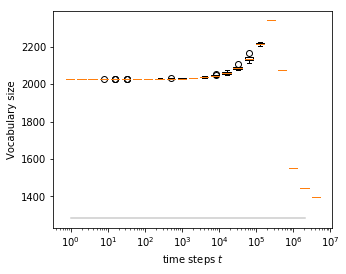

In [22]:
import os
n = {}
for file in os.listdir(path):
    if condition(file):
        all_data = pandas.read_csv(
            os.path.join(path, file),
            sep=",",
            na_values=[""],
            keep_default_na=False,
            encoding='utf-8')

        for language_id, language_data in all_data.groupby("Language_ID"):
            n.setdefault(int(language_id), []).append(vocabulary_size(language_data))

plt.boxplot(list(n.values()), positions=list(n.keys()), widths=[i/2 for i in n.keys()], manage_xticks=False)

plt.plot([1, 2*1048576], [1284, 1284], '0.8', label="Root #Words")

plt.xlabel("time steps $t$")
plt.gca().set_xscale('log')
plt.ylabel("Vocabulary size")
print("Clics: {:0.1f}±{:0.1f}".format(
    numpy.mean(clics_vocabulary), numpy.std(clics_vocabulary)))
stable = numpy.array(sum([n.get(2**i, []) for i in range(23, 27)], []))
print("Simulation: {:0.1f}±{:0.1f}".format(stable.mean(), stable.std()))
plt.gcf().set_size_inches(5,4)
plt.savefig("vocabularysize_timesteps.pdf")


In [23]:
n[2**22]

[1399]

trivial_long_branche95a_r-5_i100_w2_n0.004.csv


/usr/lib/python3.6/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/lib/python3.6/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


trivial_long_branche95a_r-6_i100_w2_n0.004.csv
trivial_long_branche95a_r-5_id199_w2.000000_n0.004.csv
trivial_long_branche95b_r-3_i100_w2_n0.004.csv
trivial_long_branch57b1_r2_i100_w2_n0.004.csv
trivial_long_branche95a_r-5_id199_w2_n0.004000.csv
trivial_long_branche95a_r-6_id199_w2_n0.004000.csv
trivial_long_branche95a_r-3_i100_w2_n0.004.csv
trivial_long_branche95a_r-4_i100_w2_n0.004.csv
trivial_long_branche95a_r-4_id199_w2_n0.004000.csv
trivial_long_branche95a_r-3_id199_w2.000000_n0.004.csv
trivial_long_branche95b_r-5_i100_w2_n0.004.csv
trivial_long_branche95a_r-4_id199_w2.000000_n0.004.csv
trivial_long_branche95a_r-6_id199_w2.000000_n0.004.csv
trivial_long_branche95b_r-6_i100_w2_n0.004.csv
trivial_long_branche95b_r-4_i100_w2_n0.004.csv
Synonymity
Polysemy


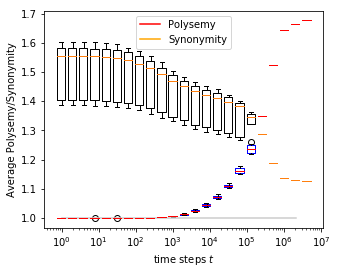

In [24]:
import os
n = {}
c = {}
p = {}
for file in os.listdir(path):
    if condition(file):
        all_data = pandas.read_csv(
            os.path.join(path, file),
            sep=",",
            na_values=[""],
            keep_default_na=False,
            encoding='utf-8')

        print(file)
        for language_id, language_data in all_data.groupby("Language_ID"):
            n.setdefault(int(language_id), []).append(synonymity(language_data))
            
            sum_width = 0
            m = 0
            accs, widths = [], []
            for form, meanings in language_data.groupby("Cognate_Set"):
                width = meanings["Weight"].sum()**2/(meanings["Weight"]**2).sum()
                accs.append(meanings["Weight"].sum())
                widths.append(width)
                sum_width += width
                m += 1
            c.setdefault(int(language_id), []).append(numpy.corrcoef(accs, widths)[1, 0])
            p.setdefault(int(language_id), []).append(sum_width/m)

plt.boxplot(list(n.values()), positions=list(n.keys()), widths=[i/2 for i in n.keys()], manage_xticks=False)
plt.boxplot(list(p.values()), positions=list(p.keys()), widths=[i/2 for i in p.keys()], manage_xticks=False,
               boxprops=dict(color='blue'), medianprops=dict(color='red'))

plt.plot([1, 2*1048576], [1, 1], '0.8')

plt.plot([0,0],[1,1],c='red',label="Polysemy")
plt.plot([0,0],[1,1],c='orange',label="Synonymity")
plt.xlabel("time steps $t$")
plt.gca().set_xscale('log')
plt.ylabel("Average Polysemy/Synonymity")
plt.legend()
print("Synonymity")
#print("Clics: {:0.1f}±{:0.1f}".format(
#    numpy.mean(clics_synonymity), numpy.std(clics_synonymity)))
stable = numpy.array([n[2**i] for i in range(20, 22)])
# print("Simulation: {:0.1f}±{:0.1f}".format(stable.mean(), stable.std()))
print("Polysemy")
# print("Clics: {:0.1f}±{:0.1f}".format(
#    numpy.mean(clics_semantic_width), numpy.std(clics_semantic_width)))
stable = numpy.array([p[2**i] for i in range(20, 22)])
#print("Simulation: {:0.1f}±{:0.1f}".format(stable.mean(), stable.std()))
plt.gcf().set_size_inches(5,4)
plt.savefig("synonymitypolysemy_timesteps.pdf")


/usr/lib/python3.6/site-packages/numpy/lib/function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/usr/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1856: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/usr/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1863: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
/usr/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1871: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
/usr/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1872: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)
No handles with labels found to put in legend.


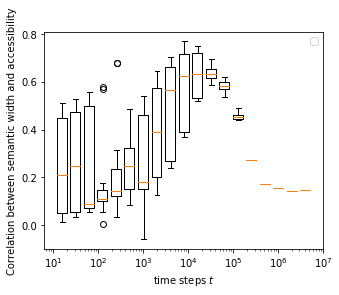

In [25]:
plt.boxplot(list(c.values()), positions=list(c.keys()), widths=[i/2 for i in c.keys()], manage_xticks=False)

plt.xlabel("time steps $t$")
plt.gca().set_xscale('log')
plt.ylabel("Correlation between semantic width and accessibility")
plt.legend()

plt.gcf().set_size_inches(5,4)
plt.savefig("correlation_timesteps.pdf")
